In [2]:
!wget https://download.openmmlab.com/mmyolo/data/balloon_dataset.zip -P data
!unzip data/balloon_dataset.zip -d data >> /dev/null # 解压压缩包

--2023-06-12 10:59:49--  https://download.openmmlab.com/mmyolo/data/balloon_dataset.zip
正在连接 172.16.0.13:5848... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度： 38741381 (37M) [application/zip]
正在保存至: “data/balloon_dataset.zip”

balloon_dataset.zip 100%[===================>]  36.95M  11.6MB/s    用时 3.2s    

2023-06-12 10:59:52 (11.6 MB/s) - 已保存 “data/balloon_dataset.zip” [38741381/38741381])



In [1]:
!pip install opencv-python pillow matplotlib seaborn tqdm pycocotools -i https://pypi.tuna.tsinghua.edu.cn/simple


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 293 kB 54.6 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=374106 sha256=892de80e7ff39db29c5867d99e78db52fa9e2ca63b05f760330287f046af310d
  Stored in directory: /home/featurize/.cache/pip/wheels/f8/94/70/046149e666bd5812b7de6b87a28dcef238f7162f4108e0b3d8
Successfully built pycocotools


In [55]:
from pycocotools.coco import COCO
import numpy as np
import os.path as osp
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [57]:
import os
os.chdir('data')

/home/featurize/data


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


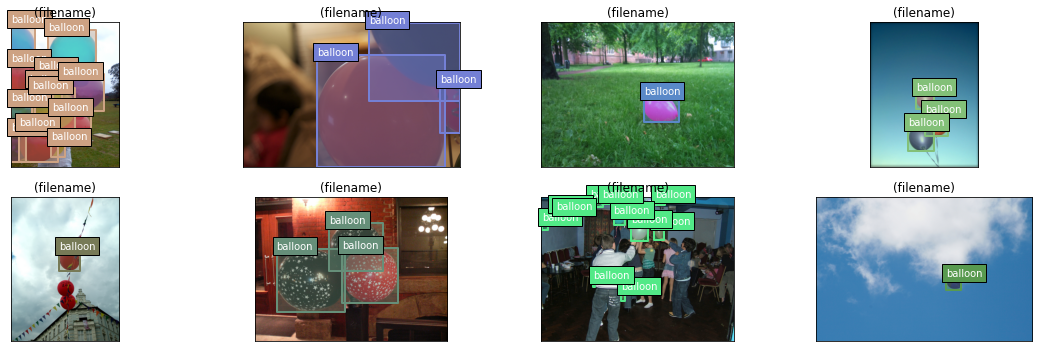

In [64]:
def apply_exif_orientation(image):
    _EXIF_ORIENT = 274
    if not hasattr(image, 'getexif'):
        return image
    try:
        exif = image.getexif()
    except Exception:
        exif = None
    if exif is None:
        return image
    orientation = exif.get(_EXIF_ORIENT)
    method = {
        2: Image.FLIP_LEFT_RIGHT,
        3: Image.ROTATE_180,
        4: Image.FLIP_TOP_BOTTOM,
        5: Image.TRANSPOSE,
        6: Image.ROTATE_270,
        7: Image.TRANSVERSE,
        8: Image.ROTATE_90,
    }.get(orientation)
    if method is not None:
        return image.transpose(method)
    return image

def show_bbox_only(coco, anns, show_label_bbox=True, is_filling=True):
    if len(anns) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)
    image2color = dict()
    for cat in coco.getCatIds():
        image2color[cat] = (np.random.random((1,3)) * .7 + .3).tolist()[0]
    polygons =[]
    colors = []
    for ann in anns:
        color = image2color[ann["category_id"]]
        bbox_x, bbox_y,bbox_w, bbox_h = ann['bbox']
        poly = [[bbox_x, bbox_y],[bbox_x, bbox_y + bbox_h],[bbox_x + bbox_w, bbox_y + bbox_h],[bbox_x + bbox_w, bbox_y]]
        polygons.append(Polygon(np.array(poly).reshape((4,2))))
        colors.append(color)

        if show_label_bbox:
            label_bbox = dict(facecolor=color)
        else:
            label_bbox = None

        ax.text(
        bbox_x,
        bbox_y,
        "%s" % (coco.loadCats(ann['category_id'])[0]['name']),
        color='white',
        bbox=label_bbox)
    if is_filling:
        p = PatchCollection(
            polygons,facecolor=colors,linewidths=0,alpha=0.4)
        ax.add_collection(p)
    p = PatchCollection(polygons,facecolor='none',edgecolors=colors,linewidths=2)
    ax.add_collection(p)


coco = COCO('balloon/train.json')
image_ids = coco.getImgIds()
np.random.shuffle(image_ids)
plt.figure(figsize=(16,5))



for i in range(8):
    image_data = coco.loadImgs(image_ids[i])[0]
    image_path = osp.join('balloon/train/',image_data['file_name'])
    annotation_ids = coco.getAnnIds(
        imgIds=image_data['id'], iscrowd=0)
    annotations = coco.loadAnns(annotation_ids)
    ax = plt.subplot(2,4,i+1)
    image = Image.open(image_path).convert("RGB")
    image=apply_exif_orientation(image)
    ax.imshow(image)
    show_bbox_only(coco, annotations)
    plt.title(f"(filename)")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.savefig('vis_annotation.png')